### Flow Matching U-Net with Time Embeddings

This is an implementation of a U-Net architecture conditioned on time embeddings for flow matching tasks. The model takes in noisy data and predicts the vector field at a given time step.

In [47]:
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

### Sinusoidal Time Embeddings and U-Net Model

We implement sinusoidal time embeddings and a U-Net architecture that incorporates these embeddings to condition the model on time.

Note that the model input is noise and the time embedding, and the output is the predicted vector field at that time step.

In [48]:
# ----------------------------
# Utilities: time embedding
# ----------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):  # t shape: (B,)
        device = t.device
        half = self.dim // 2
        emb = torch.exp(torch.arange(half, device=device) * -(math.log(10000) / (half - 1)))
        emb = t[:, None] * emb[None, :]  # (B, half)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        if self.dim % 2 == 1:  # odd dim
            emb = F.pad(emb, (0, 1))
        return emb  # (B, dim)

# ----------------------------
# Small U-Net for 1x28x28 images
# ----------------------------
def conv_block(in_c, out_c, time_emb_dim=None):
    layers = [
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.GroupNorm(8, out_c),
        nn.SiLU(),
    ]
    if time_emb_dim is not None:
        # add time-conditioned bias after conv
        layers.append(TimeCondition(out_c, time_emb_dim))
    return nn.Sequential(*layers)

class TimeCondition(nn.Module):
    def __init__(self, channels, time_emb_dim):
        super().__init__()
        self.proj = nn.Linear(time_emb_dim, channels)

    def forward(self, x):
        # this module will never be used stand-alone in my conv_block chain
        raise NotImplementedError("TimeCondition is used in UNet forward directly.")

class UNetSimple(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_emb = SinusoidalPosEmb(time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim),
        )

        # Encoder
        self.inc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32),
            nn.SiLU(),
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 28->14
            nn.GroupNorm(8, 64),
            nn.SiLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14->7
            nn.GroupNorm(8, 128),
            nn.SiLU(),
        )

        # Bottleneck
        self.mid = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
        )

        # Decoder
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7->14
            nn.GroupNorm(8, 64),
            nn.SiLU(),
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1),  # 14->28
            nn.GroupNorm(8, 32),
            nn.SiLU(),
        )

        self.outc = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32),
            nn.SiLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
        )

        # small MLP to inject time into features at each stage
        self.time_proj0 = nn.Linear(time_emb_dim, 32)
        self.time_proj1 = nn.Linear(time_emb_dim, 64)
        self.time_proj2 = nn.Linear(time_emb_dim, 128)
        self.time_proj_mid = nn.Linear(time_emb_dim, 128)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 128)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 64)

    def forward(self, x, t):
        """
        x: (B, 1, 28, 28)
        t: (B,) in [0,1]
        output: predicted velocity v(x_t, t) same shape as x
        """
        B = x.shape[0]
        te = self.time_emb(t)         # (B, time_dim)
        te = self.time_mlp(te)        # (B, time_dim)

        # encode
        e0 = self.inc(x)              # (B,32,28,28)
        e0 = e0 + self.time_proj0(te)[:, :, None, None]
        e1 = self.down1(e0)           # (B,64,14,14)
        e1 = e1 + self.time_proj1(te)[:, :, None, None]
        e2 = self.down2(e1)           # (B,128,7,7)
        e2 = e2 + self.time_proj2(te)[:, :, None, None]

        # mid
        m = self.mid(e2)
        m = m + self.time_proj_mid(te)[:, :, None, None]
        # decode
        d2 = self.up2(m)              # (B,64,14,14)
        d2 = torch.cat([d2, e1], dim=1)  # (B,128,14,14)

        d2 = d2 + self.time_proj_up1(te)[:, :, None, None]

        d1 = self.up1(d2)             # (B,32,28,28)
        d1 = torch.cat([d1, e0], dim=1)  # (B,64,28,28)
        d1 = d1 + self.time_proj_up2(te)[:, :, None, None]

        out = self.outc(d1)           # (B,1,28,28)  => velocity
        return out



### Sampler for Flow Matching using Optimal Transport

The noise sampler generates samples from the learned flow matching model using optimal transport principles. The equation used is based on the flow matching framework.

$$ x_t = (1-t) \epsilon + t z $$

The model is trained to predict the vector field that transports the noise $\epsilon$ to the data $z$ over time $t$. The model equation is given by:

$$ v_\theta(x_t, t) \approx \frac{d}{dt} x_t = z - \epsilon $$

The ground truth vector field is computed as:

$$ u_gt = z - \epsilon $$


In [49]:
# ----------------------------
# Flow matching specifics
# For linear interpolation x_t = (1 - t) * eps + t * z
# => dx_t/dt = z - eps  (simple constant velocity)
# We train network u_theta(x_t, t) to match z - eps (MSE)
# ----------------------------

def sample_xt(z, eps, t):
    # z, eps: (B, C, H, W) ; t: (B,) scalar in [0,1]
    # simple linear interpolation
    t = t.view(-1, 1, 1, 1)
    return (1 - t) * eps + t * z

def train_flowmatch(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=10,
    batch_size=128,
    lr=2e-4,
    steps_per_epoch=None,
    model_save_dir='models',
    sample_dir='samples',
    integration_steps=100,
):
    os.makedirs(model_save_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)

    transform = transforms.Compose([
        transforms.ToTensor(),             # [0,1]
        transforms.Normalize((0.5,), (0.5,))  # -> [-1,1]
    ])
    dataset = datasets.MNIST(root='~/data', download=True, train=True, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    model = UNetSimple(time_emb_dim=128).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    if steps_per_epoch is None:
        steps_per_epoch = len(loader)

    for ep in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for step, (z, _) in enumerate(loader, start=1):
            z = z.to(device)  # (B,1,28,28)
            B = z.shape[0]

            # sample noise eps ~ N(0, I) with same shape as z
            eps = torch.randn_like(z).to(device)

            # sample t ~ Uniform(0,1)
            t = torch.rand(B, device=device)

            # compute xt and target velocity u_gt = z - eps
            xt = sample_xt(z, eps, t)  # (B,1,28,28)
            u_gt = z - eps           # (B,1,28,28)  (independent of t for linear interp)

            # model predicts u_theta(xt, t)
            u_pred = model(xt, t)

            loss = mse(u_pred, u_gt)

            opt.zero_grad()
            loss.backward()
            opt.step()

            running_loss += loss.item()

            if step % 200 == 0 or step == steps_per_epoch:
                avg = running_loss / step
                print(f"Epoch {ep} Step {step}/{steps_per_epoch} Loss: {avg:.6f}")

            # limit to steps_per_epoch if specified smaller than dataset length
            if step >= steps_per_epoch:
                break

        # end epoch
        avg_epoch_loss = running_loss / steps_per_epoch
        print(f"=== Epoch {ep} completed. Avg loss: {avg_epoch_loss:.6f} ===")

        # save checkpoint
        torch.save(model.state_dict(), os.path.join(model_save_dir, f'unet_flowmatch_ep{ep}.pt'))

        # sample from the model by integrating dx/dt = v_theta(x, t) from t=0..1
        sample_and_save(model, device, sample_dir, epoch=ep, n_samples=16, steps=integration_steps)

def sample_and_save(model, device, sample_dir, epoch, n_samples=16, steps=100):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, 1, 28, 28, device=device)
        x_t = z.clone()
        dt = 1.0 / steps
        # simple Euler integration from t=0 to t=1
        for i in range(steps):
            t = torch.full((n_samples,), fill_value=i / steps, device=device)
            v = model(x_t, t)  # predict v(x_t, t)
            x_t = x_t + v * dt

        # x_t should approximate data distribution mapped at t=1
        out = (x_t.clamp(-1, 1) + 1) / 2  # map back to [0,1] for saving
        utils.save_image(out, os.path.join(sample_dir, f'samples_ep{epoch}.png'), nrow=4)
    print(f"Saved samples to {os.path.join(sample_dir, f'samples_ep{epoch}.png')}")



### Simple Model Testing with Sample Data

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
model = UNetSimple(time_emb_dim=128).to(device)
#print(model)
data = torch.randn(1, 1, 28, 28).to(device)
output = model(data, torch.tensor([0.5], device=device))
print("Output shape:", output.shape)
# number of parameters
num_params = sum(p.numel() for p in model.parameters())
# in Millions
print(f"Number of parameters in the model: {num_params / 1e6:.2f} Million")

Using device: cuda
Output shape: torch.Size([1, 1, 28, 28])
Number of parameters in the model: 0.81 Million


### Training Flow Matching Model

In [51]:
train_flowmatch(device='cuda' if torch.cuda.is_available() else 'cpu',
            epochs=10,
            batch_size=64,
            lr=2e-4,
            steps_per_epoch=600,   # speed control — set None to run full dataset
            model_save_dir='models',
            sample_dir='samples',
            integration_steps=200)

Epoch 1 Step 200/600 Loss: 0.500651
Epoch 1 Step 400/600 Loss: 0.398728
Epoch 1 Step 600/600 Loss: 0.355484
=== Epoch 1 completed. Avg loss: 0.355484 ===
Saved samples to samples/samples_ep1.png
Epoch 2 Step 200/600 Loss: 0.250375
Epoch 2 Step 400/600 Loss: 0.245938
Epoch 2 Step 600/600 Loss: 0.243141
=== Epoch 2 completed. Avg loss: 0.243141 ===
Saved samples to samples/samples_ep2.png
Epoch 3 Step 200/600 Loss: 0.231773
Epoch 3 Step 400/600 Loss: 0.228119
Epoch 3 Step 600/600 Loss: 0.225348
=== Epoch 3 completed. Avg loss: 0.225348 ===
Saved samples to samples/samples_ep3.png
Epoch 4 Step 200/600 Loss: 0.218838
Epoch 4 Step 400/600 Loss: 0.216983
Epoch 4 Step 600/600 Loss: 0.216657
=== Epoch 4 completed. Avg loss: 0.216657 ===
Saved samples to samples/samples_ep4.png
Epoch 5 Step 200/600 Loss: 0.211759
Epoch 5 Step 400/600 Loss: 0.211713
Epoch 5 Step 600/600 Loss: 0.211206
=== Epoch 5 completed. Avg loss: 0.211206 ===
Saved samples to samples/samples_ep5.png
Epoch 6 Step 200/600 Loss

### Sample Predictions After Training

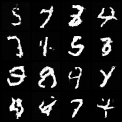

In [52]:
# display samples in notebook
from IPython.display import Image, display
display(Image(filename='samples/samples_ep10.png'))

### Sample Predicted Images after First Epoch

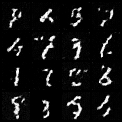

In [53]:
display(Image(filename='samples/samples_ep1.png'))